## Set-up

In [1]:
import pandas as pd
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np
import random
from tqdm.notebook import tqdm, trange

sns.set_theme()
colors = sns.color_palette("deep")

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances_argmin
from scipy.spatial.distance import cdist, euclidean
from utils import geometric_median, geometric_medoid

In [2]:
def plot_components(H, ax=None, figsize=(10, 6), title='Components found by the NMF', component_names=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.get_figure()

    n_components = H.shape[0]
    for k in range(n_components):
        if component_names is not None:
            label = component_names[k]
        else:
            label = f'Component {k + 1}'
        ax.plot(H[k, :], marker='o', linestyle='-', label=label)

    ax.set_xlabel('Hour')
    ax.set_ylabel('Load (MW)')
    ax.set_title(title)
    ax.legend()
    
    return fig, ax

In [3]:
def initialize_W(X, n_components):
    W = pd.DataFrame(np.random.rand(len(X), n_components), index=X.index, columns=[f"Component {k+1}" for k in range(n_components)])
    W = W.div(W.sum(axis=1), axis=0)
    return W

In [4]:
n_components = 4 # Number of components for the matrix factorization

colormap = ListedColormap([colors[k] for k in range(n_components)])

# Process data

## Data matrix $X$

In [5]:
input_df = pd.read_csv('data/daily_curves.csv', index_col=0)
print(len(input_df))
input_df.head(3)

11653


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Calabria_2021-01-02_Saturday,552.943,514.861,462.221,448.924,457.576,462.207,492.594,526.408,579.682,648.228,...,660.975,648.877,658.723,745.817,773.431,828.180,831.509,758.732,669.630,596.548
Calabria_2021-01-03_Holiday,518.853,457.879,432.200,419.060,393.992,438.706,462.433,488.501,532.412,641.866,...,738.739,678.540,666.579,730.333,764.207,819.056,825.176,754.773,706.062,629.708
Calabria_2021-01-04_Working day,540.431,450.024,434.019,432.949,435.210,457.071,516.980,625.155,691.067,885.798,...,780.816,845.339,798.132,870.231,891.262,980.735,926.445,845.014,756.975,688.183


In [6]:
unit_info = input_df.index.str.extract(r'^(?P<region>[\w.]+)_(?P<year>\d{4})-(?P<month>\d{2})-\d{2}_(?P<daytype>[\w ]+)$').set_index(input_df.index)
df = pd.concat([input_df, unit_info], axis=1)
# df = df[df.month.isin(months)]
# df = df[(df.month == '10')&(df.daytype=='Working day')]
print(len(df))
df.head(3)

11653


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,region,year,month,daytype
Calabria_2021-01-02_Saturday,552.943,514.861,462.221,448.924,457.576,462.207,492.594,526.408,579.682,648.228,...,773.431,828.180,831.509,758.732,669.630,596.548,Calabria,2021,01,Saturday
Calabria_2021-01-03_Holiday,518.853,457.879,432.200,419.060,393.992,438.706,462.433,488.501,532.412,641.866,...,764.207,819.056,825.176,754.773,706.062,629.708,Calabria,2021,01,Holiday
Calabria_2021-01-04_Working day,540.431,450.024,434.019,432.949,435.210,457.071,516.980,625.155,691.067,885.798,...,891.262,980.735,926.445,845.014,756.975,688.183,Calabria,2021,01,Working day


In [7]:
X = df.drop(unit_info.columns, axis=1)
X = X.div(X.sum(axis=1), axis=0)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Calabria_2021-01-02_Saturday,0.036777,0.034244,0.030743,0.029859,0.030434,0.030742,0.032763,0.035012,0.038555,0.043115,...,0.043962,0.043158,0.043813,0.049605,0.051442,0.055083,0.055305,0.050464,0.044538,0.039677
Calabria_2021-01-03_Holiday,0.034650,0.030578,0.028863,0.027986,0.026312,0.029298,0.030882,0.032623,0.035556,0.042865,...,0.049334,0.045314,0.044515,0.048773,0.051035,0.054698,0.055107,0.050405,0.047152,0.042053
Calabria_2021-01-04_Working day,0.030889,0.025722,0.024807,0.024746,0.024875,0.026124,0.029549,0.035732,0.039499,0.050629,...,0.044629,0.048316,0.045618,0.049739,0.050941,0.056055,0.052952,0.048298,0.043266,0.039334
Calabria_2021-01-05_Working day,0.034875,0.031816,0.029953,0.029646,0.028846,0.030038,0.033733,0.039128,0.043183,0.053717,...,0.044944,0.046061,0.044169,0.047396,0.051299,0.051514,0.050242,0.046238,0.039955,0.035533
Calabria_2021-01-06_Holiday,0.033596,0.029647,0.028442,0.028445,0.027932,0.028731,0.029956,0.032832,0.035834,0.046307,...,0.050172,0.047001,0.044419,0.047253,0.051327,0.052310,0.051003,0.048481,0.044442,0.040235


# NMF

In [14]:
n_runs = 10000
p = len(X.columns)

In [9]:
# Load the arrays from the .npz file
path = f'data/nmf_results/uniform_{n_components}comp_{n_runs}runs.npz'
data = np.load(path)
print('Loaded ', path)

Loaded  data/nmf_results/uniform_4comp_10000runs.npz


In [10]:
# Access the arrays
H_results = data['H_results']
W_results = data['W_results']
iterations = data['iterations']
errors = data['errors']

## Clean results

In [11]:
# Remove results for which we have less than 100 iterations (they correspond to a local minima where all profile are the same)
H_results = H_results[..., iterations > 100]
W_results = W_results[..., iterations > 100]
errors = errors[iterations > 100]
iterations = iterations[iterations > 100]
print('{} results clean'.format(W_results.shape[2]))

7919 results clean


# Results analysis

## K-means clustering to group similar profiles

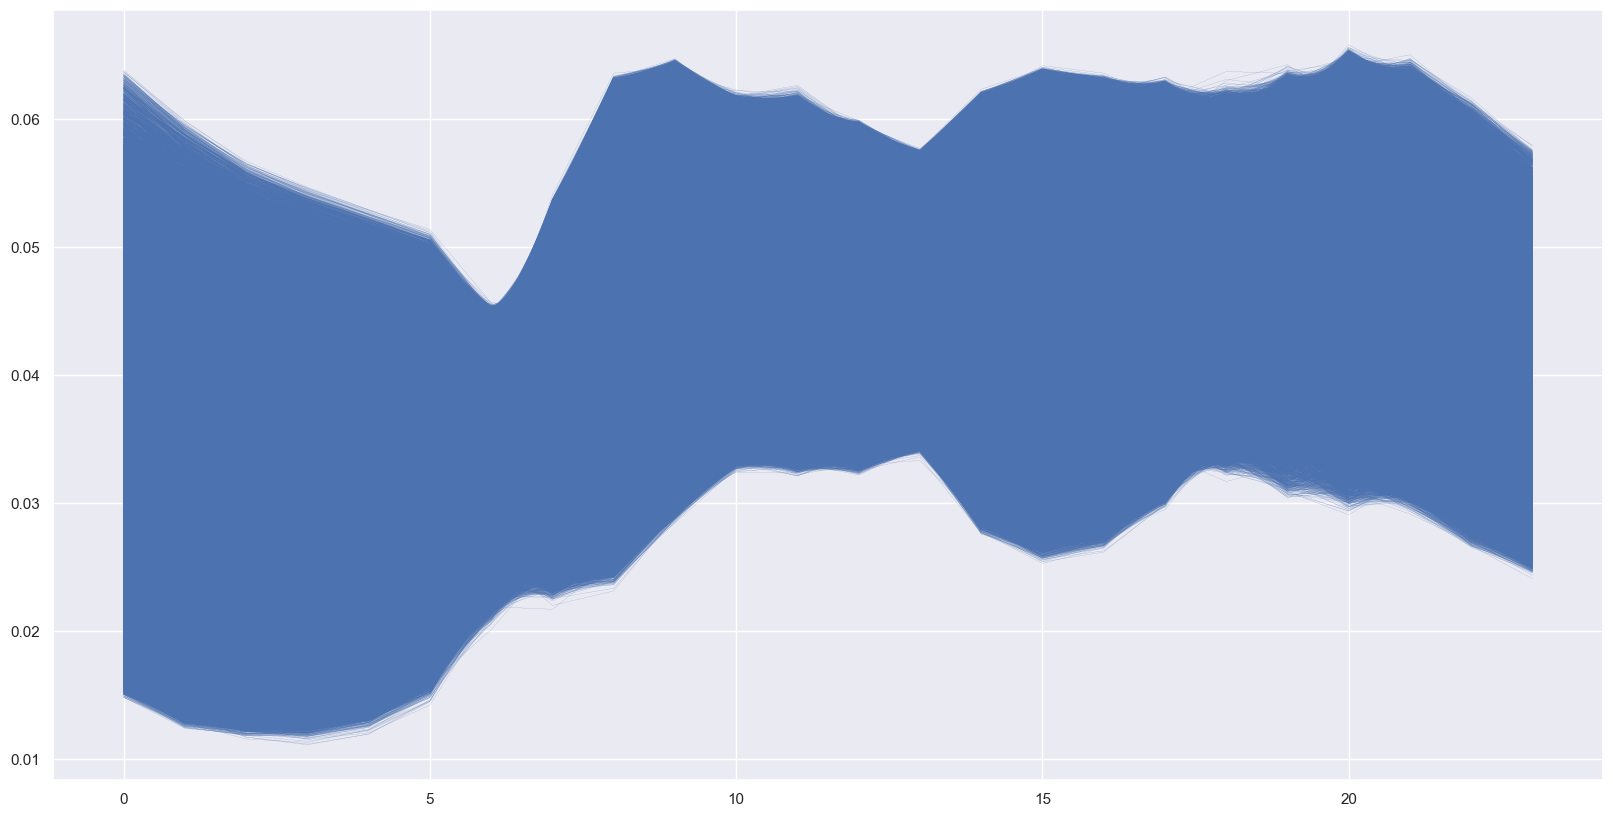

In [12]:
n_clean_runs = W_results.shape[2]
fig, ax = plt.subplots(figsize=(20, 10))

for i in range(n_clean_runs):
    for k in range(n_components):
        line, = ax.plot(H_results[k, :, i], linewidth=0.1, color=colors[0])

In [15]:
H_results_flat = H_results.transpose([0, 2, 1]).reshape((n_components * n_clean_runs, p)) # Flattening the array of profiles
kmeans = KMeans(n_clusters=n_components, n_init=10).fit(H_results_flat)

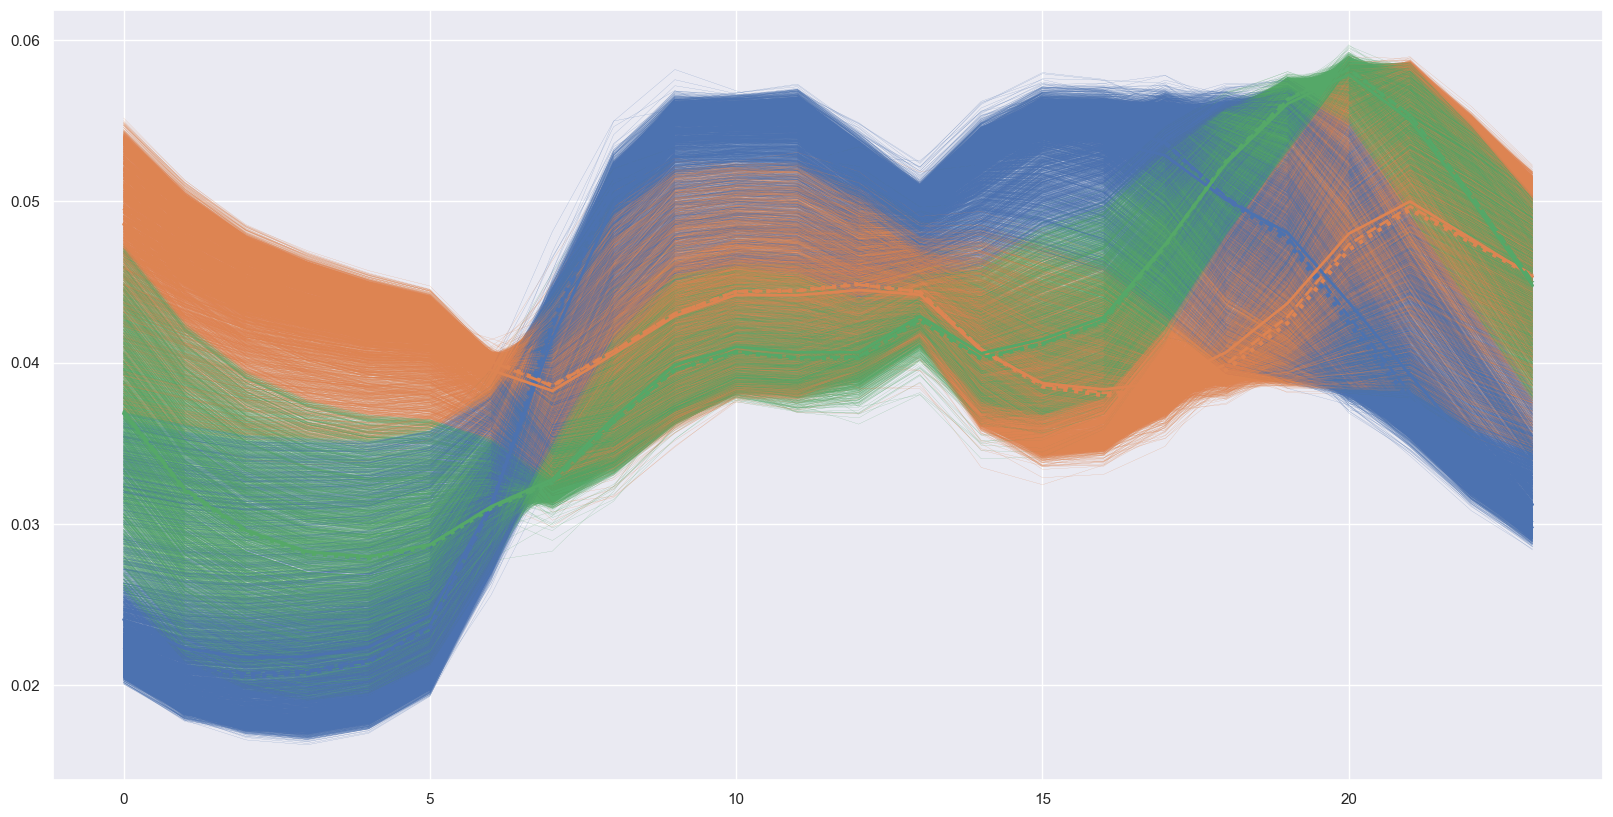

In [150]:
fig, ax = plt.subplots(figsize=(20, 10))

# Plot each profile curve coloring per cluster
for i in range(n_components * n_clean_runs):
    cluster_label = kmeans.labels_[i]
    ax.plot(H_results_flat[i, :], linewidth=0.1, color=colors[cluster_label])

# Plot cluster centroids
for i in range(n_components):
    ax.plot(kmeans.cluster_centers_[i, :], linewidth=2, color=colors[i])
    ax.plot(geometric_median(H_results_flat[kmeans.labels_ == i, :]), linewidth=2, linestyle='dashed', color=colors[i])
    ax.plot(geometric_medoid(H_results_flat[kmeans.labels_ == i, :]), linewidth=3, linestyle='dotted', color=colors[i])
    

In [16]:
# Export cluster centers
path = f'data/nmf_results/{n_components}comp_cluster_centers_{n_runs}runs.npy'
np.save(path, kmeans.cluster_centers_)
print('Saved', path)

Saved data/nmf_results/4comp_cluster_centers_10000runs.npy


Let's plot per cluster

(0.0, 0.08)

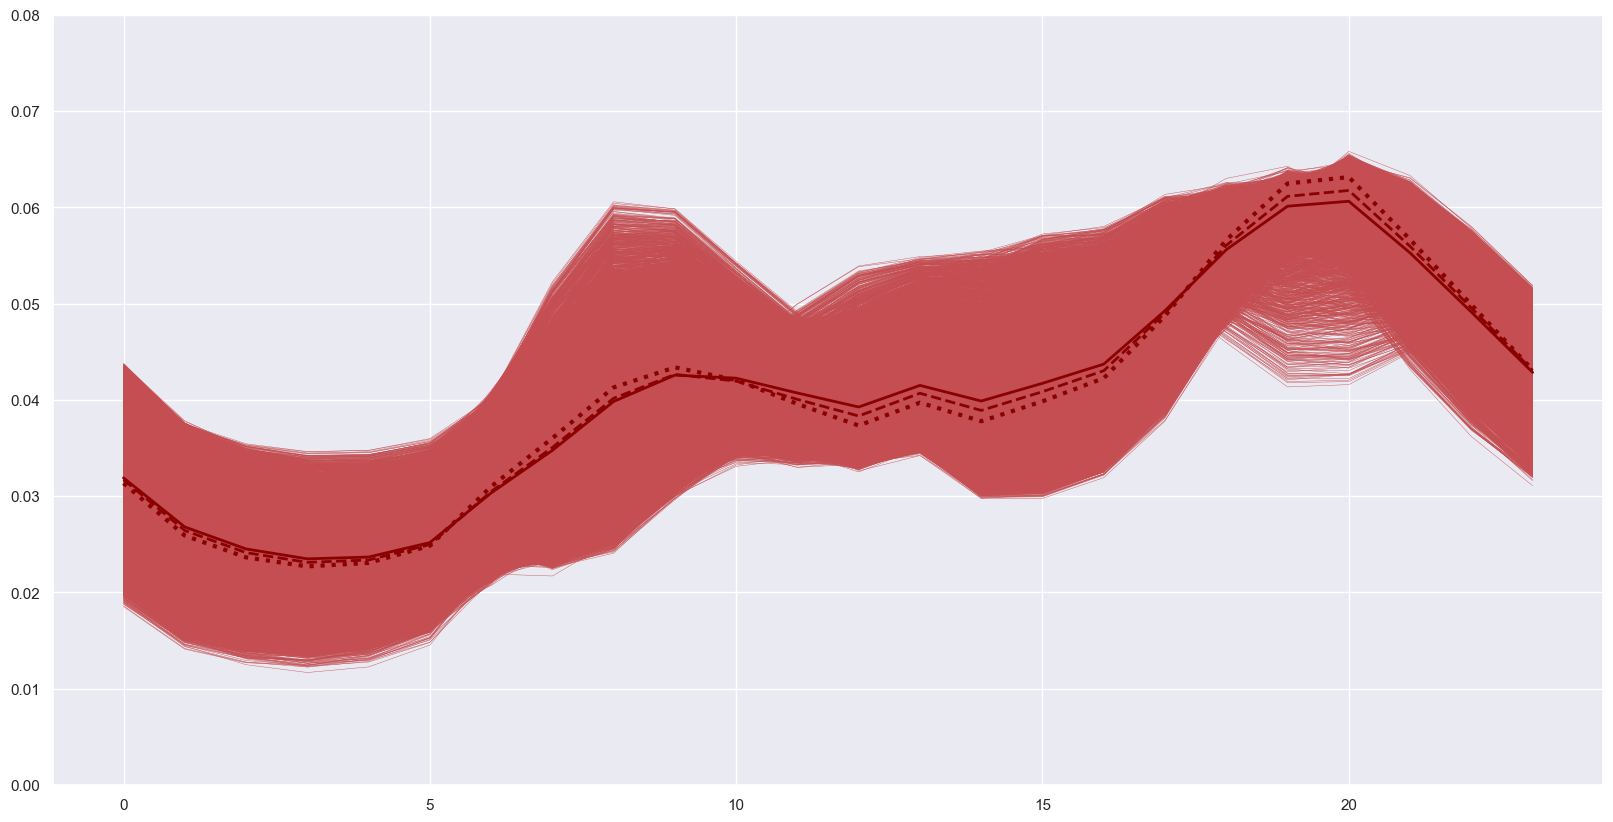

In [20]:
cluster = 3
fig, ax = plt.subplots(figsize=(20, 10))

# Plot each profile curve coloring per cluster
for i in range(n_components * n_clean_runs):
    cluster_label = kmeans.labels_[i]
    if cluster_label == cluster:
        ax.plot(H_results_flat[i, :], linewidth=0.3, color=colors[cluster_label])

# Plot cluster centroids
color = 'darkred'
# color = colors[cluster]
ax.plot(kmeans.cluster_centers_[cluster, :], linewidth=2, color=color)
ax.plot(geometric_median(H_results_flat[kmeans.labels_ == cluster, :]), linewidth=2, linestyle='dashed', color=color)
ax.plot(geometric_medoid(H_results_flat[kmeans.labels_ == cluster, :]), linewidth=3, linestyle='dotted', color=color)
ax.set_ylim((0,0.08))

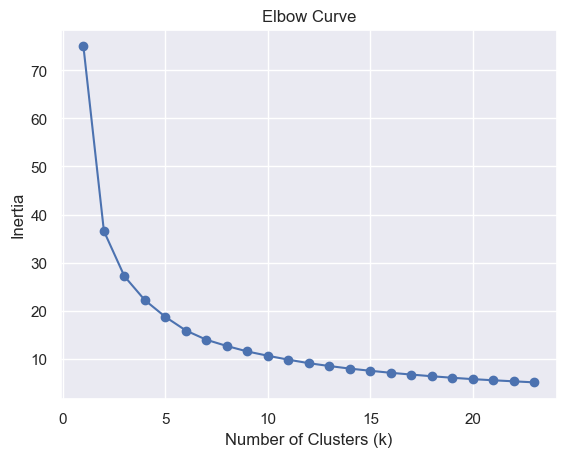

In [21]:
# Seems that there are more than 4 clusters of profiles. Let's try to find how much:

# Calculate inertia for different values of k
inertias = []
k_values = range(1, 24)
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(H_results_flat)
    inertias.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve')
plt.show()

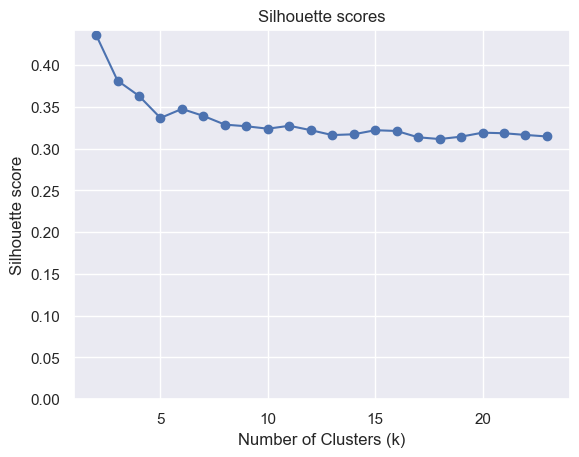

In [22]:
# Calculate silhouette score for different values of k
silhouette_scores = []
k_values = range(2, 24)
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(H_results_flat)
    labels = kmeans.labels_
    score = silhouette_score(H_results_flat, labels)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette score')
plt.title('Silhouette scores')
plt.ylim(bottom=0)
plt.show()

<Axes: >

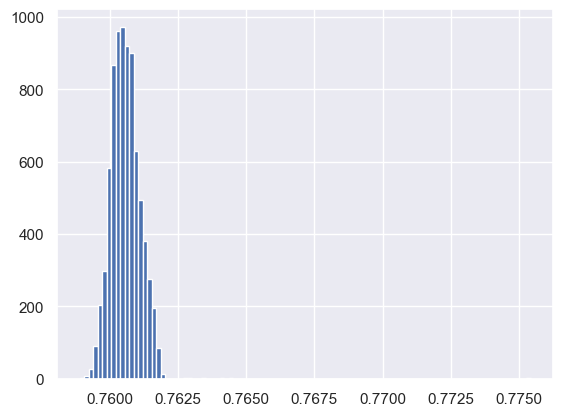

In [24]:
pd.Series(errors).hist(bins=100)

## Select the solution that is compliant to the physics of the problem

### Cyclic profiles

We want to find solutions for which
$$\text{discontinuity}(H) = \sum_{k=1}^K(H_k(p) - H_k(1))^2$$

In [25]:
H_discontinuity = ((H_results[:, 0, :] - H_results[:, p-1, :])**2).sum(axis=0)

<Axes: >

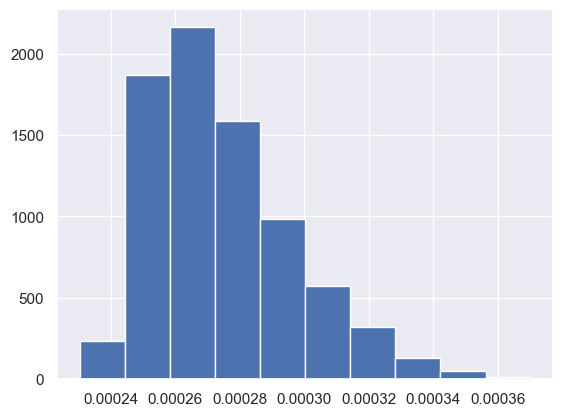

In [26]:
pd.Series(H_discontinuity).hist()

### Total distance of concentration vectors to simplex

The distance to the simplex of one observation $x$ to the simplex $\mathcal{S}(n)$ is the following
$$\text{dist}(x, \mathcal{S}(n)) = \inf_{\substack{y \in \mathcal{S}(n)}} d(x, y)$$

The point $y$ minimizing the distance is:
$$y = \frac{x}{||x||_1}$$

Here we will compute the sum of the distances to the simplex for all vector of concentrations of the matrix $W$

In [27]:
W_proj_simplex = W_results / W_results.sum(axis=1)[:, np.newaxis, :]
W_dist_simplex = np.sqrt(((W_results - W_proj_simplex)**2).sum(axis=1))
W_sum_dist_simplex = W_dist_simplex.sum(axis=0)

<Axes: >

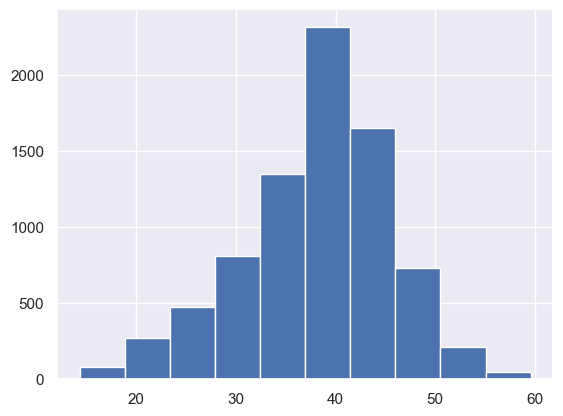

In [28]:
pd.Series(W_sum_dist_simplex).hist()

### Scatterplot of the value of the two constraints

In [29]:
import plotly.graph_objects as go

# Create a scatter plot
fig = go.Figure(
    data=go.Scatter(
        x=W_sum_dist_simplex,
        y=H_discontinuity,
        mode='markers',
        hoverinfo='text',
        text=[f'Index: {i}' for i in range(len(W_sum_dist_simplex))]
        )
    )

# Add labels and title
fig.update_layout(
    xaxis_title='Sum of distance to the simplex',
    yaxis_title='Discontinuity of the profiles',
    title='Compliance of solutions with physics of the system',
    height=1500,
    width=1500
)

# # Show the plot
# fig.show()

In [30]:
best_run = 6474

H = H_results[..., best_run]
W = W_results[..., best_run]

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Components found by the NMF'}, xlabel='Hour', ylabel='Load (MW)'>)

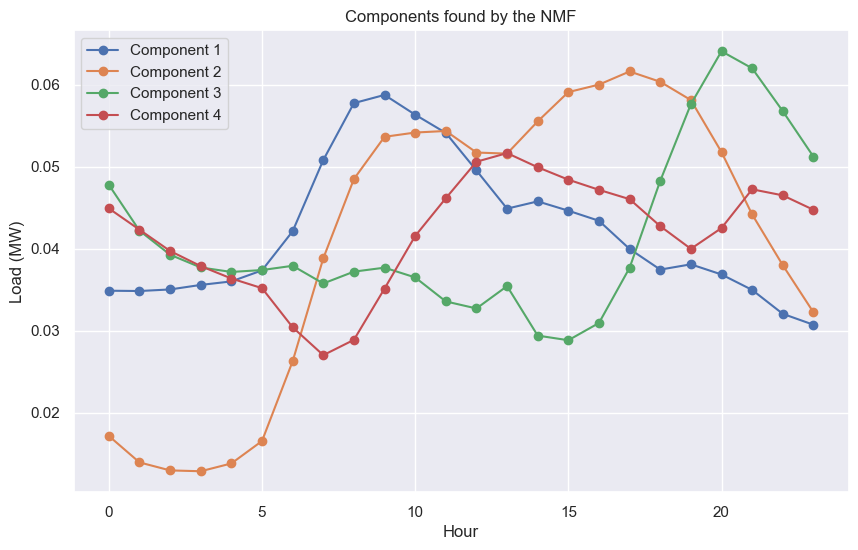

In [31]:
plot_components(H)

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Components found by the NMF'}, xlabel='Hour', ylabel='Load (MW)'>)

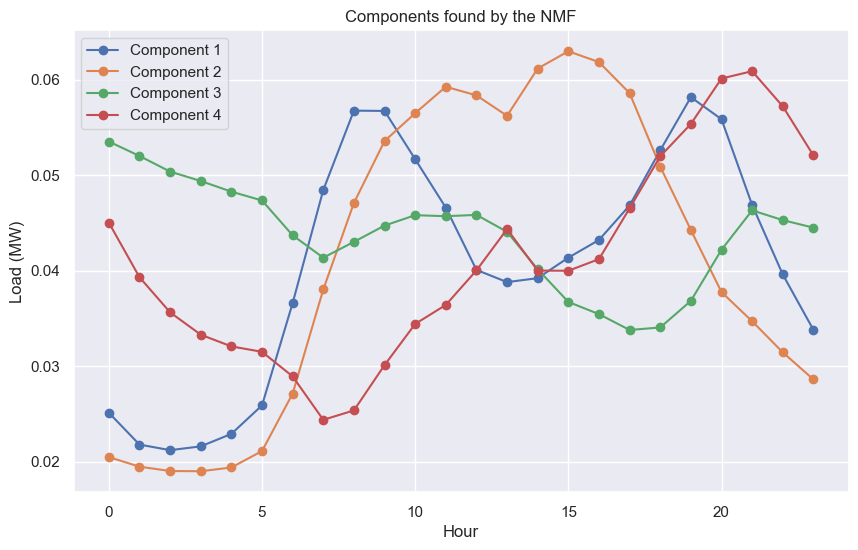

In [42]:
plot_components(H_results[...,random.randint(0, H_results.shape[2]-1)])

In [43]:
W = pd.DataFrame(W, index=df.index, columns=[f"Component {k+1}" for k in range(n_components)])
W[unit_info.columns] = df[unit_info.columns]
W

,Component 1,Component 2,Component 3,Component 4,region,year,month,daytype
Calabria_2021-01-02_Saturday,2.644152e-02,0.337861,0.388418,0.251628,Calabria,2021,01,Saturday
Calabria_2021-01-03_Holiday,2.511785e-05,0.392234,0.287213,0.328663,Calabria,2021,01,Holiday
Calabria_2021-01-04_Working day,1.202095e-01,0.520396,0.233840,0.133910,Calabria,2021,01,Working day
Calabria_2021-01-05_Working day,3.154882e-01,0.338361,0.280830,0.067355,Calabria,2021,01,Working day
Calabria_2021-01-06_Holiday,4.370406e-02,0.398189,0.183295,0.380515,Calabria,2021,01,Holiday
...,...,...,...,...,...,...,...,...
South_2022-12-27_Working day,6.853818e-02,0.560820,0.313603,0.065051,South,2022,12,Working day
South_2022-12-28_Working day,3.722240e-13,0.719407,0.103490,0.196266,South,2022,12,Working day
South_2022-12-29_Working day,2.392804e-01,0.313892,0.248717,0.200434,South,2022,12,Working day
South_2022-12-30_Working day,3.567402e-05,0.568683,0.440363,0.003004,South,2022,12,Working day


In [48]:
W[(W.region == 'North')&(W.daytype == 'Working day')].sort_index().tail(20)

,Component 1,Component 2,Component 3,Component 4,region,year,month,daytype
North_2022-12-01_Working day,0.406199,0.330494,0.120602,0.141317,North,2022,12,Working day
North_2022-12-02_Working day,0.440346,0.300948,0.081129,0.174950,North,2022,12,Working day
North_2022-12-05_Working day,0.333956,0.475638,0.054235,0.137969,North,2022,12,Working day
North_2022-12-06_Working day,0.412063,0.321053,0.133840,0.131365,North,2022,12,Working day
North_2022-12-07_Working day,0.440732,0.311182,0.124732,0.120758,North,2022,12,Working day
North_2022-12-09_Working day,0.322598,0.390159,0.109989,0.178322,North,2022,12,Working day
North_2022-12-12_Working day,0.334316,0.478465,0.068991,0.120364,North,2022,12,Working day
North_2022-12-13_Working day,0.426083,0.336163,0.038012,0.197736,North,2022,12,Working day
North_2022-12-14_Working day,0.438192,0.314156,0.073641,0.172112,North,2022,12,Working day
North_2022-12-15_Working day,0.409783,0.338637,0.028914,0.220574,North,2022,12,Working day


In [49]:
W_region = W.groupby('region')[[f"Component {k+1}" for k in range(n_components)]].sum()
W_region = W_region.div(W_region.sum(axis=1), axis=0)
W_region

,Component 1,Component 2,Component 3,Component 4
region,,,,
Calabria,0.184889,0.286017,0.297399,0.231695
Centre.North,0.280097,0.300429,0.154349,0.265125
Centre.South,0.164964,0.315343,0.237231,0.282462
North,0.332683,0.279039,0.168213,0.220065
Sardinia,0.321501,0.163351,0.279813,0.235336
Sicily,0.187568,0.230093,0.330791,0.251547
South,0.228826,0.233365,0.299365,0.238444


Text(0, 0.5, '')

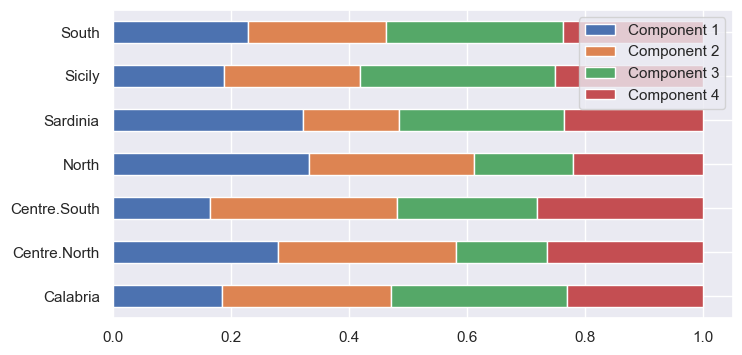

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
W_region.plot.barh(stacked=True, ax=ax)
ax.set_ylabel("")

<Axes: xlabel='component', ylabel='concentration'>

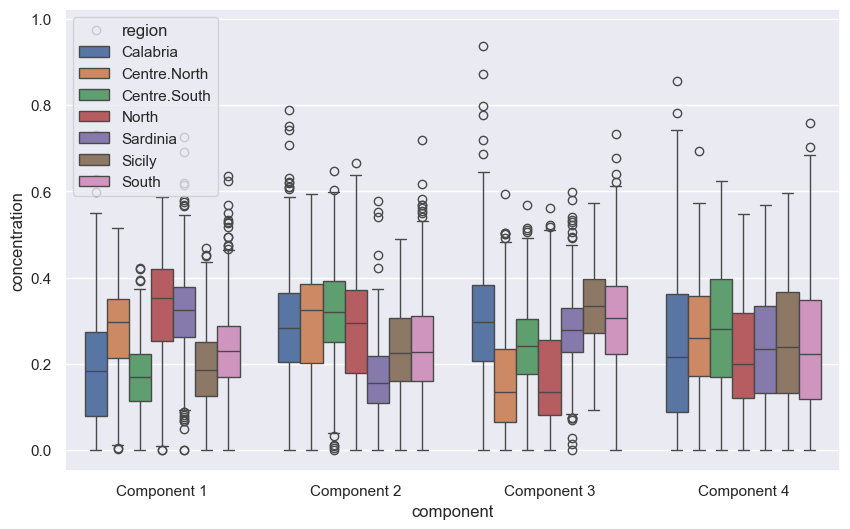

In [51]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=W.melt(id_vars=unit_info.columns.to_list(), var_name='component', value_name='concentration'),
    x='component',
    y='concentration',
    hue='region',
)

<Axes: xlabel='month', ylabel='concentration'>

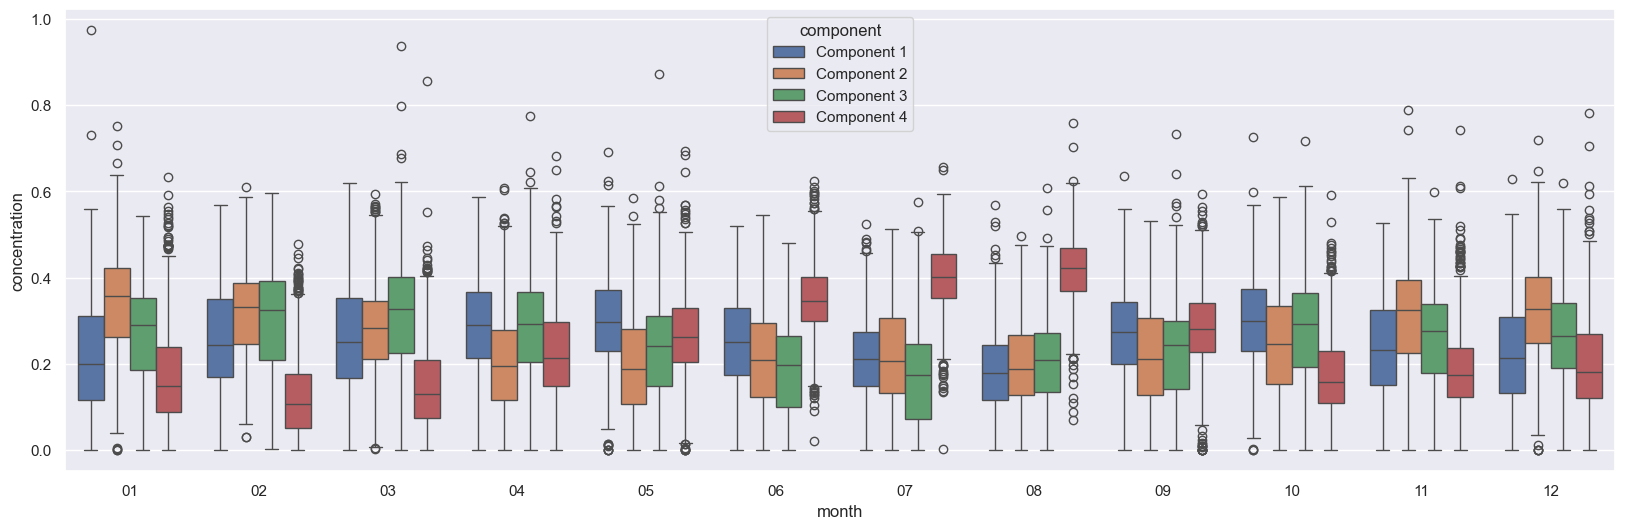

In [52]:
plt.figure(figsize=(20,6))
sns.boxplot(
    data=W.melt(id_vars=unit_info.columns.to_list(), var_name='component', value_name='concentration'),
    x='month',
    y='concentration',
    hue='component',
)

<Axes: xlabel='month', ylabel='concentration'>

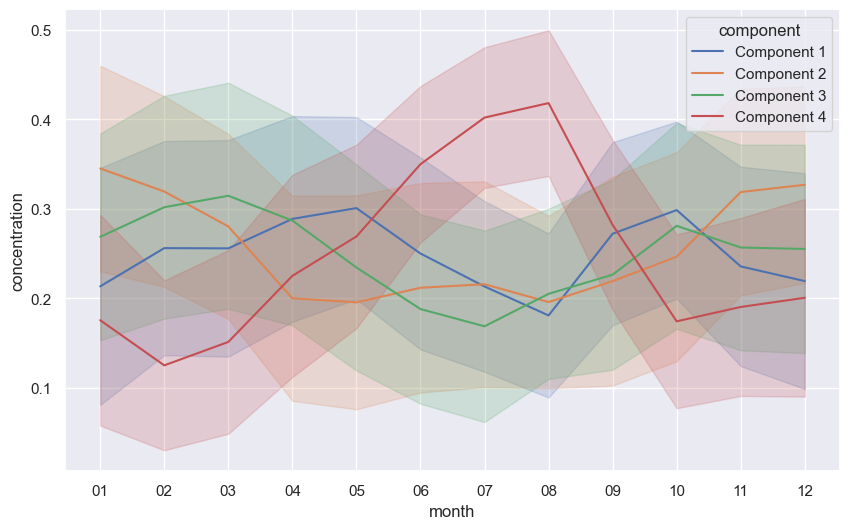

In [53]:
plt.figure(figsize=(10,6))
sns.lineplot(
    data=W.melt(id_vars=unit_info.columns.to_list(), var_name='component', value_name='concentration'),
    x='month',
    y='concentration',
    hue='component',
    errorbar='sd'
)

___

# TESTS

In [136]:
n_components_list = [3, 4]

for n_components in n_components_list:

    W_init = initialize_W(X, n_components)
    H_init = np.ones((n_components, p)) / p

    WH_init = np.dot(W_init, H_init)

    # Load the arrays from the .npz file
    data = np.load(f'data/nmf_results/uniform_{n_components}comp.npz')

    iterations = data['iterations']
    H_results = data['H_results'][..., iterations > 100]
    W_results = data['W_results'][..., iterations > 100]

    random_obs = random.randint(0, W_results.shape[2]-1)

    W_random = W_results[..., random_obs]
    H_random = H_results[..., random_obs]

    WH_random = np.dot(W_random, H_random)

    X_fpca = pd.read_csv(f'data/daily_curves_reconstructed_{n_components}PCs.csv', index_col=0)

    # Compute the Frobenius norm between X and the product W_init * H_init
    frobenius_norm_init = np.linalg.norm(X - WH_init, 'fro')
    frobenius_norm_final = np.linalg.norm(X - WH_random, 'fro')
    frobenius_norm_fpca = np.linalg.norm(X - X_fpca, 'fro')

    print(f'### {n_components} components ###')
    print("Frobenius Norm of the initial residual matrix:", frobenius_norm_init)
    print("Frobenius Norm of the final residual matrix:", frobenius_norm_final)
    print("Frobenius Norm of the FPCA residual matrix:", frobenius_norm_fpca)
    print('\n')

### 3 components ###
Frobenius Norm of the initial residual matrix: 3.7358385772724887
Frobenius Norm of the final residual matrix: 0.949199529377695
Frobenius Norm of the FPCA residual matrix: 0.7711263023212324


### 4 components ###
Frobenius Norm of the initial residual matrix: 3.7358385772724887
Frobenius Norm of the final residual matrix: 0.7607376211325353
Frobenius Norm of the FPCA residual matrix: 0.6634465209563668




In [175]:
errors[iterations > 100][420]

1.014558911529895

<Axes: >

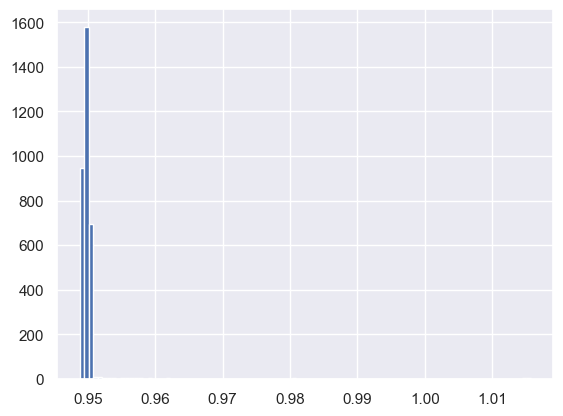

In [182]:
pd.Series(errors[(iterations > 100)&(errors < 1.02)]).hist(bins=100)

In [185]:
pd.Series(errors[iterations > 100]).quantile(np.linspace(0, 1, 21))

0.00    0.948813
0.05    0.949157
0.10    0.949219
0.15    0.949280
0.20    0.949347
0.25    0.949416
0.30    0.949504
0.35    0.949591
0.40    0.949683
0.45    0.949768
0.50    0.949838
0.55    0.949911
0.60    0.949965
0.65    0.950022
0.70    0.950074
0.75    0.950133
0.80    0.950188
0.85    0.950248
0.90    0.950300
0.95    0.950378
1.00    1.162256
dtype: float64

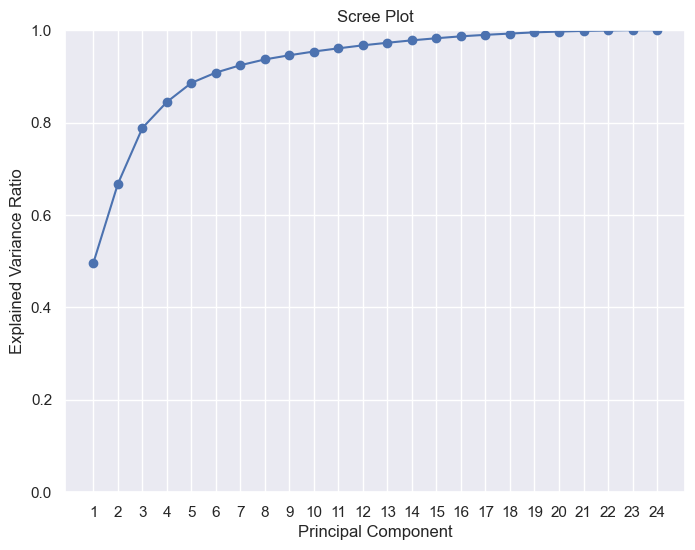

In [74]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X)

# Scree plot
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, pca.n_components_ + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-')
# plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker='o', linestyle='-')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(np.arange(1, pca.n_components_ + 1))
plt.ylim((0,1))
plt.grid(True)
plt.show()

In [75]:
np.cumsum(pca.explained_variance_ratio_)

array([0.49630093, 0.66741324, 0.78837141, 0.84461045, 0.88591071,
       0.90821743, 0.92415001, 0.93673463, 0.94572021, 0.95382268,
       0.96067938, 0.96721481, 0.97276266, 0.97799972, 0.98254862,
       0.98667156, 0.98989461, 0.99267498, 0.99526384, 0.99697613,
       0.99841413, 0.99930394, 1.        , 1.        ])

In [57]:
# Perform PCA
pca = PCA(n_components='mle')
X_pca = pca.fit_transform(X)

In [58]:
pca.n_components_

23